# Disaster Tweet Classification with RNN (LSTM/GRU)

This project is **Natural Language Processing with Disaster Tweets** using recurrent neural networks. The objective is to predict whether a tweet refers to an actual disaster. The official training set contains **7613** tweets, each with an identifier (`id`), optional `keyword` and `location`, the `text` of the tweet, and a binary `target` indicating whether it describes a disaster (1) or not (0). The test set contains **3263** tweets without `target` labels.  The dataset is drawn from Kaggle’s *NLP with Disaster Tweets* competition.

Kaggle reference (APA format):

> Kaggle. (2020). *Natural Language Processing with Disaster Tweets* [Data set]. Kaggle. https://www.kaggle.com/competitions/nlp-getting-started/data


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.4 MB/s eta 0:00:00


In [24]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

## Data Summary
- In the Kaggle dataset, there are **10,876** tweets with five columns: `id`, `keyword`, `location`, `text`, and `target`.
- The dataset is already split into a train and test set. The training data has 7,613 rows and the testing data has 3,263 rows.
- The `target` column is `1` for tweets describing disasters and `0` for non-disaster tweets.
- The dataset includes a balanced mix of disaster and non‑disaster tweets (3,271 disaster tweets vs 4,342 non-disaster tweets).
- Missing values occur in the `keyword` and `location` columns.

In [35]:
# Load train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Concatenate to create full dataset
df = pd.concat([train_df, test_df])
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [26]:
# Basic information about the dataset
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print('\nData types:')
print(df.dtypes)

Number of rows: 10876
Number of columns: 5

Data types:
id            int64
keyword      object
location     object
text         object
target      float64
dtype: object


## Exploratory Data Analysis (EDA)

We first explore the training dataset to understand its size, structure, and class distribution.  Understanding class imbalance is important when evaluating model performance.  We also check for missing values in the `keyword` and `location` fields and examine tweet lengths.


#### Target Class Distribution

Target class distribution (0=non-disaster, 1=disaster):
target
0.0    4342
1.0    3271
Name: count, dtype: int64 



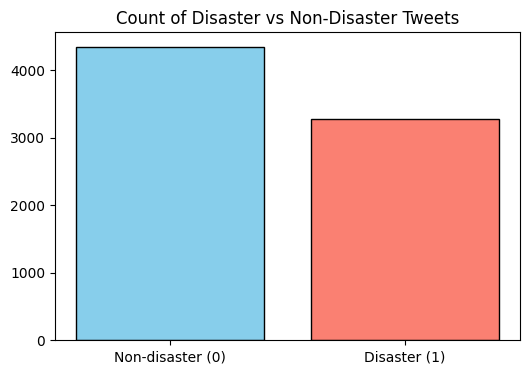

In [27]:
# Target class distribution
print('Target class distribution (0=non-disaster, 1=disaster):')
print(df['target'].value_counts(), '\n')

# Plot distribution
counts = df['target'].value_counts().sort_index()  # ensure order 0 then 1
plt.figure(figsize=(6, 4))
bars = plt.bar(
    ['Non-disaster (0)', 'Disaster (1)'],
    counts.values,
    color=['skyblue', 'salmon'],
    edgecolor='black'
)
plt.title('Count of Disaster vs Non-Disaster Tweets')
plt.xticks(rotation=0)
plt.show()

> The target shows some class imbalance:  
>   - Non-Disaster = 57% of target values
>   - Disaster = 43% of target values

#### MIssing Values

In [28]:
print('Missing values per column:')
print(df.isnull().sum(), '\n')

Missing values per column:
id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64 



> Note: the `target` column has 3263 missing values because `test_df` doesn't include target values.

#### Word Count Distributions

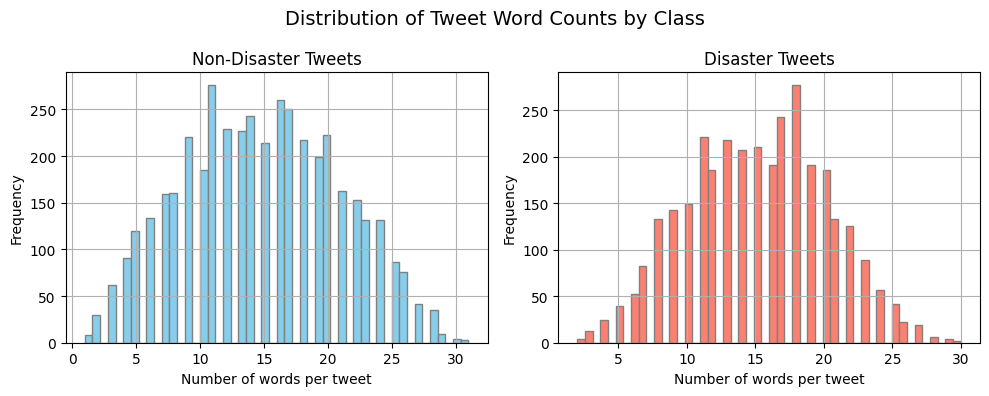

In [29]:
# Add tweet length column
train_df['length'] = train_df['text'].apply(lambda x: len(x.split()))

# Create side-by-side histograms
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
train_df[train_df['target'] == 0]['length'].hist(bins=50, color='skyblue', edgecolor='grey')
plt.title('Non-Disaster Tweets')
plt.xlabel('Number of words per tweet')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
train_df[train_df['target'] == 1]['length'].hist(bins=50, color='salmon', edgecolor='grey')
plt.title('Disaster Tweets')
plt.xlabel('Number of words per tweet')
plt.ylabel('Frequency')

plt.suptitle('Distribution of Tweet Word Counts by Class', fontsize=14)
plt.tight_layout()
plt.show()

> Both the Non-Disaster and Disaster tweets appear to be somewhat normally distributed.

#### Frequent Keywords

In [36]:
# Unique keywords
df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [31]:
# Replace '%20' with spaces
df['keyword'] = df['keyword'].str.replace('%20', ' ')

abcdefghijklmnopqrstuvwxyz

In [32]:
# Create a dictionary to map similar keywords to a single representative keyword
keyword_mapping = {
    'airplane accident': 'accident', 'accident': 'accident',
    # 'annihilation':'annihilated',
    # 'attacked': 'attack',
    'blew up': 'bomb', 'bombed': 'bomb', 'bombing': 'bomb', 'suicide bomb': 'bomb', 'suicide bomber': 'bomb',
        'suicide bombing': 'bomb', 'detonate': 'bomb', 'detonation': 'bomb',
    'body bag': 'body bagging', 'body bags': 'body bagging',
    'casualty': 'casualties',
    'bridge collapse': 'collapse', 'collapsed': 'collapse', 'structural failure': 'collapse',
    'collide': 'collision', 'collided': 'collision', 'crash': 'collision', 'crashed': 'collision',
    'harm': 'danger', 'threat': 'danger', 'trouble': 'danger', 'hazard': 'danger', 'hazardous': 'danger',
    'derail': 'derailment', 'derailed': 'derailment',
    'destroy': 'destruction', 'destroyed': 'destruction', 'flattened': 'destruction', 'razed': 'destruction',
        'demolish': 'destruction', 'demolished': 'destruction', 'devastated': 'destruction',
        'obliterated': 'destruction', 'obliteration': 'destruction',
    'drown': 'drowning', 'drowned': 'drowning', 'drowning': 'drowning',
    'earthquakes': 'earthquake', 'epicentre': 'earthquake', 'seismic': 'earthquake',
    # 'chemical emergency': 'emergency', 'emergency plan': 'emergency',
    'electrocute': 'electrocuted',
    'police': 'emergency services', 'siren': 'emergency services', 'sirens': 'emergency services',
        'stretcher': 'emergency services', 'rescue': 'emergency services', 'rescued': 'emergency services',
        'rescuers': 'emergency services', 'first responders': 'emergency services',
    'evacuate': 'evacuation', 'evacuated': 'evacuation',
    'explode': 'explosion', 'exploded': 'explosion', 'explosion': 'explosion', 'loud bang': 'explosion',
    # 'cliff fall': 'fall',
    'flooding': 'flood', 'floods': 'flood',
    'fire truck': 'fire', 'hellfire': 'fire', 'bush fires': 'fire', 'forest fire': 'fire',
        'forest fires': 'fire', 'wild fires': 'fire', 'wildfire': 'fire', 'buildings on fire': 'fire',
        'fire': 'fire', 'burned': 'fire', 'smoke': 'fire',
    'hail': 'hailstorm',
    'hijack': 'hijacking', 'hijacker': 'hijacking',
    'heat wave': 'heat',
    'hostage': 'hostages',
    'injured': 'injury', 'injuries': 'injury', 'wounded': 'injury', 'wounds': 'injury',
    'mass murder': 'massacre', 'mass murderer': 'massacre',
    'meltdown': 'nuclear disaster', 'nuclear reactor': 'nuclear disaster', 'radiation emergency': 'nuclear disaster',
    'quarantine': 'quarantine', 'quarantined': 'quarantine',

    # 'survive': 'survivors', 'survived': 'survivors',
    'bioterror': 'terrorism', 'terrorist': 'terrorism',
    # 'trapped': 'trauma', 'traumatised': 'trauma',
    'violent storm': 'storm', 'storm': 'storm', 'rainstorm': 'storm', 'snowstorm': 'storm',
        'windstorm': 'storm', 'cyclone': 'storm', 'dust storm': 'storm', 'lightning': 'storm',
        'sandstorm': 'storm', 'tornado': 'storm', 'thunder': 'thunderstormstorm', 'twister': 'storm',
        'typhoon': 'storm', 'whirlwind': 'storm',
    'lava': 'volcano',
    'military': 'war', 'war zone': 'war',

    # 'panicking': 'panic',
    # 'screamed': 'screaming', 'screams': 'screaming',
    # 'inundated': 'inundation', 'inundation': 'inundation',
    'pandemonium': 'chaos', # Pandemonium is chaos


    'natural disaster': 'natural disaster',
    'mudslide': 'natural disaster',
    'tsunami': 'natural disaster',
    'sunk': 'natural disaster', 'sinkhole': 'natural disaster',

    'oil spill': 'spill', # Oil spill is a type of spill
    'outbreak': 'disease', # Outbreak is related to disease

    'refugees': 'displaced', # Refugees are displaced people

    'riot': 'riot', 'rioting': 'riot',
    'rubble': 'wreckage', # Rubble is wreckage
    'tragedy': 'disaster', # Tragedy is a type of disaster
    'upheaval': 'disruption', # Upheaval is a disruption
    'weapon': 'weapon', 'weapons': 'weapon',
    'wreck': 'wreckage', 'wrecked': 'wreckage',

}

# Replace keywords using the mapping
df['keyword'] = df['keyword'].replace(keyword_mapping)

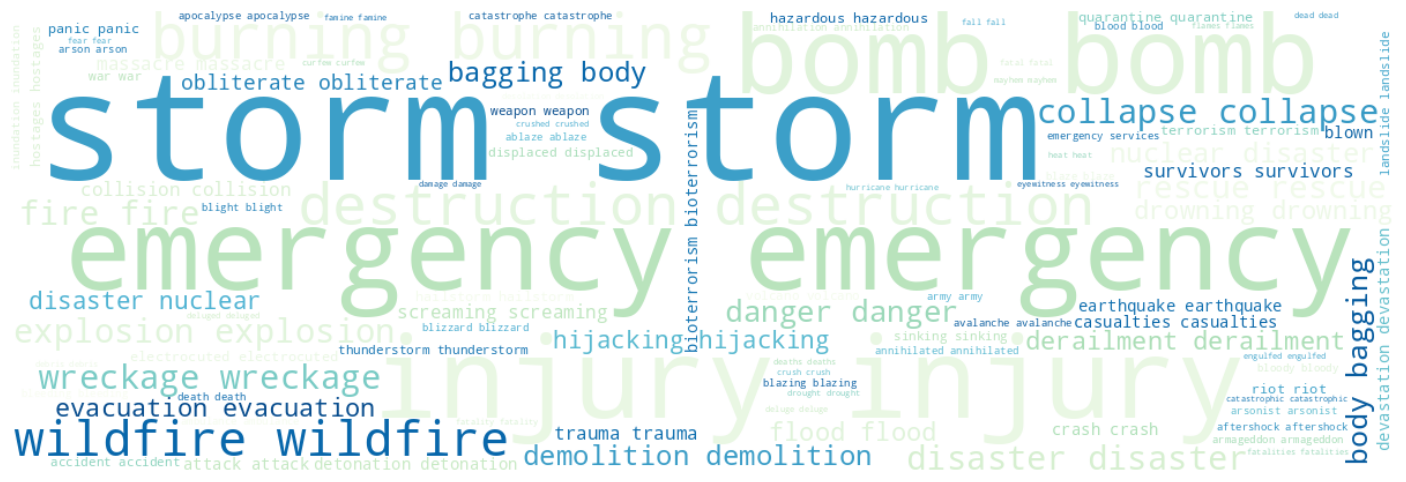

In [33]:
# Drop missing keywords and combine into a single string
keywords_text = ' '.join(df['keyword'].dropna())

# Generate word cloud
wordcloud = WordCloud(
    width=1200,
    height=400,
    background_color='white',
    colormap='GnBu_r',
    max_words=100
).generate(keywords_text)

# Display the word cloud
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## RNN Model Architecture

I'm testing two neural network architectures:

1. **LSTM** model: Embedding → LSTM → Dense
2. **Bidirectional GRU** model: Embedding → Bidirectional(GRU) → Dense

Both models use an Embedding layer to learn word vectors during training. The models are compiled with the binary cross‑entropy loss and evaluated using accuracy and F1‑score. A validation split from the training data is used to monitor performance and prevent overfitting via early stopping.

#### Text Preprocessing

I preprocess the text by cleaning and tokenizing. Using `tf.keras.preprocessing.text.Tokenizer`, I convert each tweet into a sequence of integer indices, keeping only the most frequent words. Sequences are padded to a uniform length using `tf.keras.preprocessing.sequence.pad_sequences`.

In [13]:
# Convert text column
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

# Tokenization
max_words = 20000  # vocabulary size
max_len = 30       # maximum sequence length

# Fit tokenizer on training text
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

y = train_df['target'].values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define model architectures
embedding_dim = 64


#### LSTM Model

In [15]:
# LSTM model
lstm_model = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train with early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks)

# Evaluate on validation set
lstm_val_pred = (lstm_model.predict(X_val) > 0.5).astype(int)
lstm_accuracy = accuracy_score(y_val, lstm_val_pred)
lstm_f1 = f1_score(y_val, lstm_val_pred)
print(f'LSTM Validation Accuracy: {lstm_accuracy:.4f}')
print(f'LSTM Validation F1: {lstm_f1:.4f}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.6065 - loss: 0.6514 - val_accuracy: 0.7925 - val_loss: 0.4552
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.8550 - loss: 0.3775 - val_accuracy: 0.7997 - val_loss: 0.4636
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9206 - loss: 0.2466 - val_accuracy: 0.7689 - val_loss: 0.5383
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
LSTM Validation Accuracy: 0.7925
LSTM Validation F1: 0.7143


#### Bidirectional GRU Model


In [16]:
# Bidirectional GRU model
gru_model = Sequential([
    Embedding(max_words, embedding_dim),
    Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.summary()

# Train with early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
gru_history = gru_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks)

# Evaluate GRU
gru_val_pred = (gru_model.predict(X_val) > 0.5).astype(int)
gru_accuracy = accuracy_score(y_val, gru_val_pred)
gru_f1 = f1_score(y_val, gru_val_pred)
print(f'Bidirectional GRU Validation Accuracy: {gru_accuracy:.4f}')
print(f'Bidirectional GRU Validation F1: {gru_f1:.4f}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.5949 - loss: 0.6549 - val_accuracy: 0.7735 - val_loss: 0.4855
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.8502 - loss: 0.3693 - val_accuracy: 0.8043 - val_loss: 0.4524
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.9236 - loss: 0.2097 - val_accuracy: 0.7866 - val_loss: 0.5128
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.9507 - loss: 0.1499 - val_accuracy: 0.7919 - val_loss: 0.5726
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
Bidirectional GRU Validation Accuracy: 0.8043
Bidirectional GRU Validation F1: 0.7612


#### LSTM Model (Hyperparameter Tuned)


In [17]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, hp.Int('embedding_dim', min_value=32, max_value=128, step=32)))
    model.add(LSTM(
        hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout',min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner for LSTM
lstm_tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Run the search for LSTM
print("Running KerasTuner search for LSTM model...")
lstm_tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

# Get the best LSTM model
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]

# Evaluate the best LSTM model
lstm_val_pred = (best_lstm_model.predict(X_val) > 0.5).astype(int)
lstm_accuracy = accuracy_score(y_val, lstm_val_pred)
lstm_f1 = f1_score(y_val, lstm_val_pred)
print(f'Best Hyperparameter Tuned LSTM Validation Accuracy: {lstm_accuracy:.4f}')
print(f'Best Hyperparameter Tuned LSTM Validation F1: {lstm_f1:.4f}')

Trial 10 Complete [00h 02m 19s]
val_accuracy: 0.810899555683136

Best val_accuracy So Far: 0.810899555683136
Total elapsed time: 00h 12m 30s
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Best Hyperparameter Tuned LSTM Validation Accuracy: 0.8109
Best Hyperparameter Tuned LSTM Validation F1: 0.7666


#### Bidirectional GRU Model (Hyperparameter Tuned)

In [18]:
def build_gru_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, hp.Int('embedding_dim', min_value=32, max_value=128, step=32)))
    model.add(Bidirectional(GRU(
        hp.Int('gru_units', min_value=32, max_value=128, step=32),
        dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1))
    ))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner for GRU
gru_tuner = kt.Hyperband(
    build_gru_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name='gru_tuning'
)

# Run the search for GRU
print("Running KerasTuner search for Bidirectional GRU model...")
gru_tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

# Get the best GRU model
best_gru_model = gru_tuner.get_best_models(num_models=1)[0]

# Evaluate the best GRU model
gru_val_pred = (best_gru_model.predict(X_val) > 0.5).astype(int)
gru_accuracy = accuracy_score(y_val, gru_val_pred)
gru_f1 = f1_score(y_val, gru_val_pred)
print(f'Best Hyperparameter Tuned Bidirectional GRU Validation Accuracy: {gru_accuracy:.4f}')
print(f'Best Hyperparameter Tuned Bidirectional GRU Validation F1: {gru_f1:.4f}')

Trial 10 Complete [00h 02m 36s]
val_accuracy: 0.8082731366157532

Best val_accuracy So Far: 0.8161523342132568
Total elapsed time: 00h 17m 57s
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
Best Hyperparameter Tuned Bidirectional GRU Validation Accuracy: 0.8162
Best Hyperparameter Tuned Bidirectional GRU Validation F1: 0.7701


### Results and Analysis

| Model | Accuracy | F1‑score |
|---|---|---|
| LSTM | 0.7925 | 0.7143 |
| Bidirectional GRU | 0.8043 | 0.7612 |
| LSTM (hyperparameter tuned) | 0.8109 | 0.7666 |
| Bidirectional GRU (hyperparameter tuned) | 0.8162 | 0.7701 |

In [ ]:
# Define best model
best_model = best_gru_model

# Predict best model
pred_test = (best_model.predict(X_test_seq) > 0.5).astype(int).flatten()

# Create Kaggle submission dataframe
submission = pd.DataFrame({'id': test_df['id'], 'target': pred_test})

# Save to CSV (path can be changed for local use)
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)
print('Submission file saved to', submission_path)

Kaggle results:


## Conclusion
- Discuss and interpret results as well as learnings and takeaways.
- What did and did not help improve the performance of your models?
- What improvements could you try in the future?
